## 9번. 선형적으로 분리되는 데이터셋에 LinearSVC를 훈련시켜보세요. 그런 다음 같은 데이터셋에 SVC와 SGDClassifier를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [73]:
from sklearn.model_selection import GridSearchCV
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 하이퍼파라미터 그리드 설정
param_grid_svc = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
param_grid_lin_svc = {'C': [0.01, 0.1, 1, 10, 100]}
param_grid_sgd = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

# SVC 모델
svc_grid_search = GridSearchCV(SVC(), param_grid_svc, cv=5)
svc_grid_search.fit(X_scaled, y)

# LinearSVC 모델
lin_svc_grid_search = GridSearchCV(LinearSVC(loss="hinge", dual=True, random_state=42), param_grid_lin_svc, cv=5)
lin_svc_grid_search.fit(X_scaled, y)

# SGDClassifier 모델
sgd_grid_search = GridSearchCV(SGDClassifier(random_state=42), param_grid_sgd, cv=5)
sgd_grid_search.fit(X_scaled, y)

print(svc_grid_search.best_params_)
print(lin_svc_grid_search.best_params_)
print(sgd_grid_search.best_params_)

{'C': 0.01, 'kernel': 'linear'}
{'C': 0.01}
{'alpha': 0.0001}


In [74]:
# 최적의 모델로 다시 학습
best_svc = svc_grid_search.best_estimator_
best_lin_svc = lin_svc_grid_search.best_estimator_
best_sgd = sgd_grid_search.best_estimator_

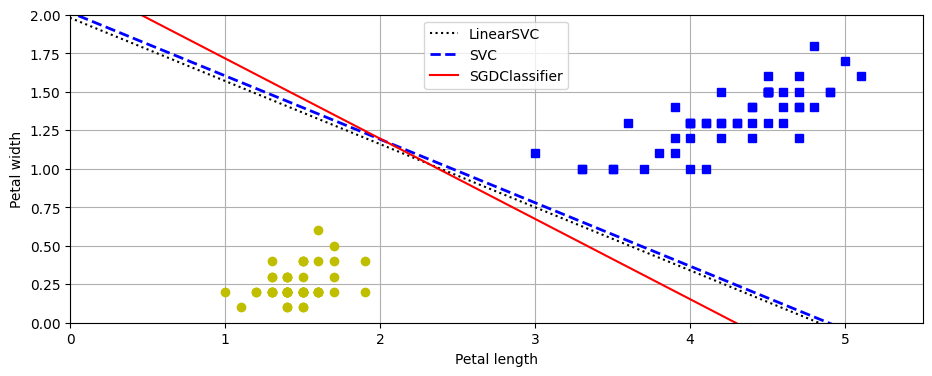

In [75]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(best_lin_svc)
svc_line = compute_decision_boundary(best_svc)
sgd_line = compute_decision_boundary(best_sgd)

plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()


##  10번. sklearn.datasets.load_wine()을 사용해 로드할 수 있는 와인 데이터셋에서 SVM 분류기를 훈련

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

In [98]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


wine = load_wine(as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, random_state=42)

In [99]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [100]:
y_train.head()

,target
2,0
100,1
122,1
154,2
51,0


### LinearSVC

In [108]:
lin_clf = make_pipeline(StandardScaler(), LinearSVC(dual=True, random_state=42))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=True, random_state=42))])

In [111]:
# 교차 검증
lin_accuracy = cross_val_score(lin_clf, X_train, y_train).mean()
print(lin_accuracy)

0.9774928774928775


### 커널 SVM

In [113]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
svm_accuracy = cross_val_score(svm_clf, X_train, y_train).mean()
print(svm_accuracy)

0.9698005698005698


In [115]:
# 하이퍼파라미터 튜닝을 위한 RandomizedSearchCV
param_distrib = {
    "svc__gamma": loguniform(0.001, 0.1),
    "svc__C": uniform(1, 10)
}

rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5, random_state=42)
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(random_state=42))]),
                   n_iter=100,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78b53095ded0>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78b53081f110>},
                   random_state=42)

In [118]:
# 최적 모델 출력
best_model = rnd_search_cv.best_estimator_
best_accuracy = rnd_search_cv.best_score_
print(best_accuracy)

0.9925925925925926


In [119]:
# 테스트 세트
test_accuracy = rnd_search_cv.score(X_test, y_test)
print(test_accuracy)

테스트 세트 정확도: 0.9778


### wine 데이터셋 - 다항 특성 시각화

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-126-ccc9f826b87c>:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


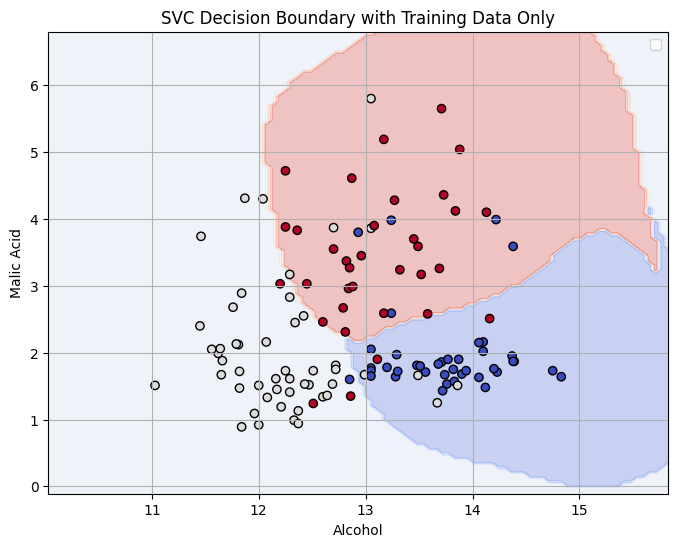

In [126]:
import matplotlib.pyplot as plt

wine = load_wine(as_frame=True)

# 2개의 특성 선택 (alcohol, malic_acid)
X = wine.data[['alcohol', 'malic_acid']]
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
svm_clf.fit(X_train, y_train)

x_min, x_max = X_train['alcohol'].min() - 1, X_train['alcohol'].max() + 1
y_min, y_max = X_train['malic_acid'].min() - 1, X_train['malic_acid'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

Z = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)


plt.scatter(X_train['alcohol'], X_train['malic_acid'], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')


plt.xlabel("Alcohol")
plt.ylabel("Malic Acid")
plt.title("SVC Decision Boundary with Training Data Only")
plt.legend(loc="best")
plt.grid(True)
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
<ipython-input-131-409c18e10aa6>:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


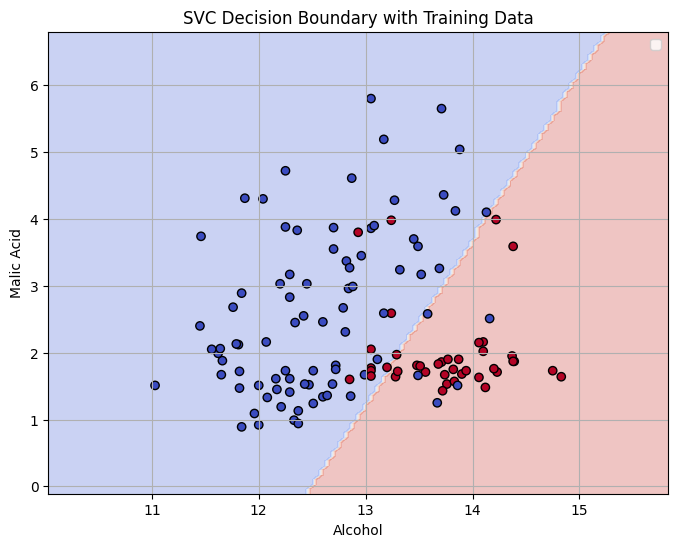

In [131]:

import matplotlib.pyplot as plt

wine = load_wine(as_frame=True)

# 2개의 클래스만 선택 (class_0, class_1)
X = wine.data[['alcohol', 'malic_acid']]
y = wine.target
y = (y == 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
svm_clf.fit(X_train, y_train)

x_min, x_max = X_train['alcohol'].min() - 1, X_train['alcohol'].max() + 1
y_min, y_max = X_train['malic_acid'].min() - 1, X_train['malic_acid'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

Z = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))


plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

plt.scatter(X_train['alcohol'], X_train['malic_acid'], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')

# 레이블과 제목 추가
plt.xlabel("Alcohol")
plt.ylabel("Malic Acid")
plt.title("SVC Decision Boundary with Training Data")
plt.legend(loc="best")
plt.grid(True)
plt.show()

